In [1]:
import pandas as pd
import numpy as np
np.random.seed(524)

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder#, MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

In [2]:
# The factor of the dataset to use for training vs 
TRAIN_SCALE = 0.7

In [3]:
data = {
    'tra': pd.read_csv('data/air/air_visit_data.csv'),
    'as': pd.read_csv('data/air/air_store_info.csv'),
    'hs': pd.read_csv('data/hpg/hpg_store_info.csv'),
    'ar': pd.read_csv('data/air/air_reserve.csv'),
    'hr': pd.read_csv('data/hpg/hpg_reserve.csv'),
    'id': pd.read_csv('data/store_id_relation.csv'),
    'tes': pd.read_csv('sample_submission.csv'),
    'hol': pd.read_csv('data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
}

# Merge store id relation data onto HPG data
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

#### splitting up datetimes

In [4]:
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})

In [5]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

#### engineering visitor statistics on a store by store basis

In [6]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])

#### label encoding restaurant data and holiday data

In [7]:
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id'])
lbl = LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

#### setting up train and test data

In [8]:
train = pd.merge(data['tra'], stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

# deal with missing data
train = train.fillna(-1)
test = test.fillna(-1)

#### defining error function

In [9]:
def rmse(y, pred):
    return mean_squared_error(y, pred) ** 0.5

normalize

In [10]:
values = train.sort_values('visit_date')
values = (train['visitors'].values).reshape(-1,1)
values = values.astype('float32')
"""
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
"""
scaled = values

split into train and test sets

In [11]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size

train = train.drop(["air_store_id", "visit_date", "visitors"], axis=1)

X_train, X_test = train.iloc[0:train_size,:], train.iloc[train_size:len(train),:]
y_train, y_test = scaled[0:train_size,:].ravel(), scaled[train_size:len(scaled),:].ravel()
print(len(y_train), len(y_test))

176475 75633


In [12]:
tsplit = TimeSeriesSplit(n_splits=5)

model = lgb.LGBMModel(
    boosting = "gbdt",
    objective = "regression",
    learning_rate = 0.01,
    num_leaves = 35,
    n_estimators = 39000,
    min_child_weight = 0.001,
    min_split_gain = 0,
    bagging_freq = 3,
    bagging_fraction = 0.8,
    feature_fraction = 0.8
)

#param_grid = {
#    'learning_rate': [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1],
#    'min_child_weight': [1e-3, 1e-2, 1e-1],
#    'num_leaves': [20,25,30,35],
#    'bagging_freq': [0,1,2,3,4,5]
#}

#gbm = GridSearchCV(model, param_grid, n_jobs=-1, cv=tsplit, scoring="neg_mean_squared_error", verbose=2)
#gbm.fit(X_train, y_train, eval_metric="rmse", verbose=20)
#print("Best params:", gbm.best_params_)

model.fit(X_train, y_train, eval_metric="rmse", verbose=20)

LGBMModel(bagging_fraction=0.8, bagging_freq=3, boosting='gbdt',
     boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
     feature_fraction=0.8, learning_rate=0.01, max_depth=-1,
     min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
     n_estimators=39000, n_jobs=-1, num_leaves=35, objective='regression',
     random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
     subsample=1.0, subsample_for_bin=200000, subsample_freq=1,
     verbose=100)

In [13]:
yhat = model.predict(X_test)#.reshape((-1, 1))

#X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[2]))
## Invert scaling for forecast
#inv_yhat = np.concatenate((yhat, X_test.iloc[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]
## Invert scaling for actual
#y_test = y_test.reshape((len(y_test), 1))
#inv_y = np.concatenate((y_test, X_test.iloc[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = (inv_y[:,0])

Test RMSE: 10.737
641.7885785674162


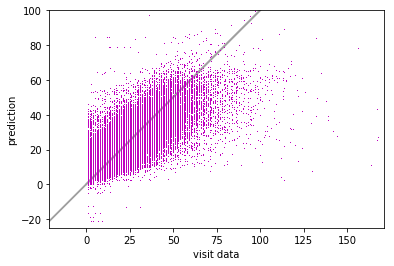

In [14]:
lgbm_rmse = rmse(y_test, yhat)
print('Test RMSE: %.3f' % lgbm_rmse)
plt.plot((y_test), (yhat), "m,")
plt.xlabel("visit data")
plt.ylabel("prediction")
plt.axis("equal")
plt.axis([0,150,-25,100])
print(max(y_test) - max(yhat))

# plotting identity function
lims = plt.axis()
plt.plot(lims, lims, '0.5', alpha=0.75, zorder=0)

In [17]:
x = list(set(test.columns) - {"id", "visitors", "air_store_id", "visit_date"})
test_yhat = model.predict(test[x])#.reshape((-1, 1))
test_yhat -= min(test_yhat)

# X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[2]))
# Invert scaling for forecast
#test_inv_yhat = np.concatenate((test_yhat, test[x].iloc[:, 1:]), axis=1)
#test_inv_yhat = scaler.inverse_transform(test_inv_yhat)
#test_inv_yhat = np.expm1(test_inv_yhat[:,0])

test["visitors"] = test_yhat

test[["id", "visitors"]].to_csv("LGB_CV_sub.csv", index=False)

#### todo:

- try removing outliers (visits > 300?)